In [1]:
pip install numpy==1.23.5 #need to downgrade otherwise bool8 error again

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 73.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
datasets 3.5.0 requires fsspec[http]<=2024.12.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
woodwork 0.31.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
featuretools 1.31.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.


In [2]:
pip install box2d


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 36.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install "gym[atari,accept-rom-license]"

INFO: pip is looking at multiple versions of gym[accept-rom-license,atari] to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 10.1 MB/s eta 0:00:0000:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 21.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.7 MB/s eta 0:00:0000:01
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827730 sha256=e6281b2d1fc079145e092d7da40ef3f5cf5ef18812adf54122069d2726162c11
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
  Created wheel for AutoROM.accept-rom-license: filena

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

class Policy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, act_dim),
        )

    def forward(self, x):
        return self.net(x)

    def get_action(self, obs):
        logits = self.forward(obs)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        logp = dist.log_prob(action)
        return action, logp, logits

    def get_log_probs(self, obs, action):
        logits = self.forward(obs)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        return dist.log_prob(action)

class Value(nn.Module):
    def __init__(self, obs_dim, hidden_size=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)


#UTILS
def compute_gae(rewards, values, masks, gamma=0.99, lam=0.95):
    advantages = []
    gae = 0
    values = values + [0]
    for step in reversed(range(len(rewards))):
        delta = rewards[step] + gamma * values[step + 1] * masks[step] - values[step]
        gae = delta + gamma * lam * masks[step] * gae
        advantages.insert(0, gae)
    return advantages


#CNN
class CNNPolicy(nn.Module):
    def __init__(self, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),  # (4, 84, 84) -> (32, 20, 20)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),  # -> (64, 9, 9)
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),  # -> (64, 7, 7)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, act_dim),
        )

    def forward(self, x):
        return self.net(x / 255.0)  # normalize if you not normalized earlier

    def get_action(self, obs):
        logits = self.forward(obs)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action, dist.log_prob(action), logits

    def get_log_probs(self, obs, action):
        logits = self.forward(obs)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        return dist.log_prob(action)

class CNNValue(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        return self.net(x / 255.0).squeeze(-1)

import cv2
#Pong util
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[34:194]
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    frame = frame / 255.0
    return frame

In [ ]:
def collect_batch(env, policy, value_fn, batch_size):
    obs_list, act_list, old_logp_list, logits_list = [], [], [], []
    rew_list, val_list, mask_list = [], [], []
    episode_returns = []

    result = env.reset()
    if isinstance(result, tuple):
        obs, _ = result
    else:
        obs = result

    done = False
    steps = 0
    episode_reward = 0

    while steps < batch_size:
        # obs_tensor = torch.tensor(obs, dtype=torch.float32)

        # logits = policy(obs_tensor)
        # probs = torch.softmax(logits, dim=-1)
        # dist = torch.distributions.Categorical(probs)
        # action = dist.sample()
        # logp = dist.log_prob(action)

        if isinstance(obs, np.ndarray):
            obs_array = obs
        else:
            obs_array = np.array(obs, copy=False)  # <-- fix for LazyFrames

        obs_tensor = torch.from_numpy(obs_array).float().unsqueeze(0)

        action, logp, logits = policy.get_action(obs_tensor)
        value = value_fn(obs_tensor)

        result = env.step(action.item())
        if len(result) == 5:
            next_obs, reward, terminated, truncated, _ = result
            done = terminated or truncated
        else:
            next_obs, reward, done, _ = result

        obs_list.append(obs_tensor.squeeze(0))
        act_list.append(action)
        old_logp_list.append(logp.detach())
        logits_list.append(logits.detach())
        rew_list.append(reward)
        val_list.append(value)
        mask_list.append(1 - int(done))

        episode_reward += reward
        obs = next_obs
        steps += 1

        if done:
            episode_returns.append(episode_reward)
            episode_reward = 0
            result = env.reset()
            if isinstance(result, tuple):
                obs, _ = result
            else:
                obs = result

    return obs_list, act_list, old_logp_list, logits_list, rew_list, val_list, mask_list, episode_returns

def train(env, agent, config):
    batch_size = config["batch_size"]
    mini_batch_size = config["mini_batch_size"]
    total_steps = config["total_steps"]
    epochs = config["epochs"]

    reward_history = []
    moving_avg_rewards = deque(maxlen=10)
    steps_collected = 0

    while steps_collected < total_steps:
        (obs_list, act_list, old_logp_list, logits_list,
         rew_list, val_list, mask_list, ep_returns) = collect_batch(env, agent.policy, agent.value_fn, batch_size)
        steps_collected += len(rew_list)

        values = [v.item() for v in val_list]
        advantages = compute_gae(rew_list, values, mask_list, config["gamma"], config["gae_lambda"])
        returns = [a + v for a, v in zip(advantages, values)]

        obs_batch = torch.stack(obs_list)
        act_batch = torch.stack(act_list)
        old_logp_batch = torch.stack(old_logp_list)
        old_logits_batch = torch.stack(logits_list)
        adv_batch = torch.tensor(advantages, dtype=torch.float32)
        ret_batch = torch.tensor(returns, dtype=torch.float32)

        adv_batch = (adv_batch - adv_batch.mean()) / (adv_batch.std() + 1e-8)

        idxs = np.arange(batch_size)
        for _ in range(epochs):
            np.random.shuffle(idxs)
            for start in range(0, batch_size, mini_batch_size):
                end = start + mini_batch_size
                mb_idx = idxs[start:end]

                mb_obs = obs_batch[mb_idx]
                mb_act = act_batch[mb_idx]
                mb_adv = adv_batch[mb_idx]
                mb_ret = ret_batch[mb_idx]
                mb_old_logits = old_logits_batch[mb_idx]

                loss = agent.compute_loss(mb_obs, mb_act, mb_adv, mb_ret, mb_old_logits)

                agent.policy.zero_grad()
                agent.value_fn.zero_grad()
                loss.backward()
                optimizer.step()

        avg_reward = np.mean(ep_returns)
        moving_avg_rewards.append(avg_reward)
        moving_avg = np.mean(moving_avg_rewards)

        print(f"Steps {steps_collected}: Avg Reward = {avg_reward:.2f}, Moving Avg (10) = {moving_avg:.2f}")
        reward_history.append(moving_avg)

    plt.plot(reward_history)
    plt.title("Training Progress")
    plt.xlabel("Evaluation Step")
    plt.ylabel("Moving Avg Reward")
    plt.grid()
    plt.show()


def evaluate(env, policy, num_episodes=10):
    total_reward = 0.0

    for _ in range(num_episodes):
        result = env.reset()
        if isinstance(result, tuple):
            obs, _ = result
        else:
            obs = result

        done = False
        episode_reward = 0.0

        while not done:
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            logits = policy(obs_tensor)
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample().item()

            result = env.step(action)
            if len(result) == 5:
                next_obs, reward, terminated, truncated, _ = result
                done = terminated or truncated
            else:
                next_obs, reward, done, _ = result

            episode_reward += reward
            obs = next_obs

        total_reward += episode_reward

    avg_reward = total_reward / num_episodes
    return avg_reward


In [6]:
class GeneralAgent:
    def __init__(self, policy, value_fn, config):
        self.policy = policy
        self.value_fn = value_fn
        self.config = config
        self.algo = config.get("algo", "GRPO")  # Options: GRPO, GRPO_KL, PPO_CLIP, PPO_KL, A2C

    def compute_loss(self, mb_obs, mb_act, mb_adv, mb_ret, mb_old_logits=None):
        logits = self.policy(mb_obs)
        probs = torch.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        logp = dist.log_prob(mb_act)
        entropy = dist.entropy().mean()

        value = self.value_fn(mb_obs)
        policy_loss = None

        if self.algo == "GRPO":
            policy_loss = -(mb_adv.detach() * logp).mean()

        elif self.algo == "GRPO_KL":
            policy_loss = -(mb_adv.detach() * logp).mean()
            if mb_old_logits is not None:
                old_probs = torch.softmax(mb_old_logits, dim=-1)
                kl = (old_probs * (torch.log(old_probs + 1e-8) - torch.log(probs + 1e-8))).sum(-1).mean()
                policy_loss += self.config.get("kl_coeff", 0.5) * kl

        elif self.algo == "PPO_CLIP":
            with torch.no_grad():
                old_probs = torch.softmax(mb_old_logits, dim=-1)
                old_dist = torch.distributions.Categorical(old_probs)
                old_logp = old_dist.log_prob(mb_act)

            ratio = torch.exp(logp - old_logp)
            clip_eps = self.config.get("clip_eps", 0.2)
            clipped_ratio = torch.clamp(ratio, 1 - clip_eps, 1 + clip_eps)

            policy_loss = -torch.min(ratio * mb_adv.detach(), clipped_ratio * mb_adv.detach()).mean()

        elif self.algo == "PPO_KL":
            with torch.no_grad():
                old_probs = torch.softmax(mb_old_logits, dim=-1)
            kl = (old_probs * (torch.log(old_probs + 1e-8) - torch.log(probs + 1e-8))).sum(-1).mean()

            policy_loss = -(mb_adv.detach() * logp).mean()
            policy_loss += self.config.get("kl_coeff", 0.5) * kl

        elif self.algo == "A2C":
            policy_loss = -(mb_adv.detach() * logp).mean()

        else:
            raise ValueError(f"Unknown algo {self.algo}")

        value_loss = ((value - mb_ret) ** 2).mean()
        loss = policy_loss + value_loss

        if self.config.get("entropy_bonus", True):
            loss -= self.config.get("entropy_coeff", 0.01) * entropy

        return loss



=== Running GRPO on MountainCar-v0 ===


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Steps 8192: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 16384: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 24576: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 32768: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 40960: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 49152: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 57344: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 65536: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 73728: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 81920: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 90112: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 98304: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 106496: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 114688: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 122880: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 131072: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 139264: Avg Rew

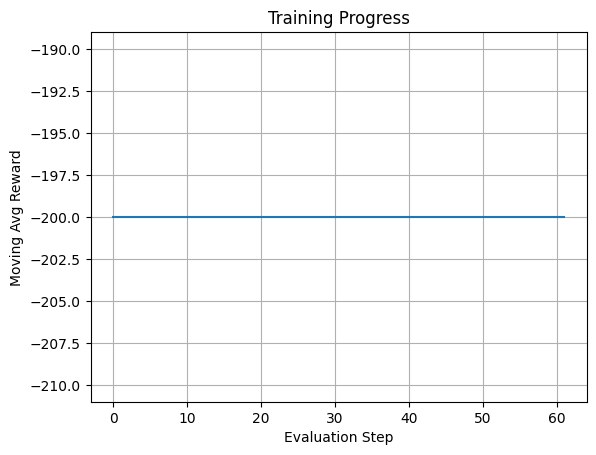

=== GRPO on MountainCar-v0 Final Reward: -200.00

=== Running GRPO_KL on MountainCar-v0 ===


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Steps 8192: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 16384: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 24576: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 32768: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 40960: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 49152: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 57344: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 65536: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 73728: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 81920: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 90112: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 98304: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 106496: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 114688: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 122880: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 131072: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 139264: Avg Rew

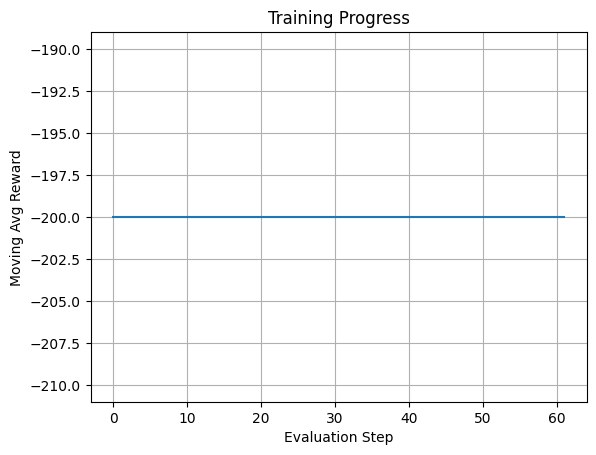

=== GRPO_KL on MountainCar-v0 Final Reward: -200.00

=== Running PPO_CLIP on MountainCar-v0 ===


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Steps 8192: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 16384: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 24576: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 32768: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 40960: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 49152: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 57344: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 65536: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 73728: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 81920: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 90112: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 98304: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 106496: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 114688: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 122880: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 131072: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 139264: Avg Rew

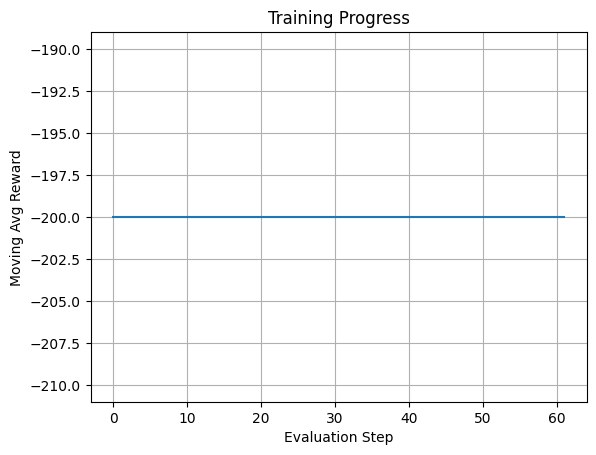

=== PPO_CLIP on MountainCar-v0 Final Reward: -200.00

=== Running PPO_KL on MountainCar-v0 ===


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Steps 8192: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 16384: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 24576: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 32768: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 40960: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 49152: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 57344: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 65536: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 73728: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 81920: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 90112: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 98304: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 106496: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 114688: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 122880: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 131072: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 139264: Avg Rew

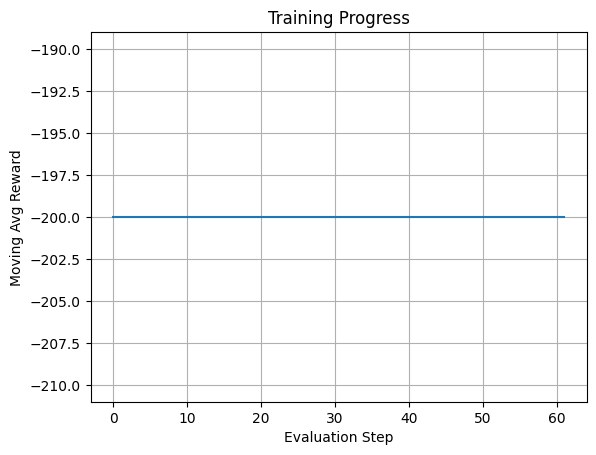

=== PPO_KL on MountainCar-v0 Final Reward: -200.00

=== Running A2C on MountainCar-v0 ===


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Steps 8192: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 16384: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 24576: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 32768: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 40960: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 49152: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 57344: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 65536: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 73728: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 81920: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 90112: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 98304: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 106496: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 114688: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 122880: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 131072: Avg Reward = -200.00, Moving Avg (10) = -200.00
Steps 139264: Avg Rew

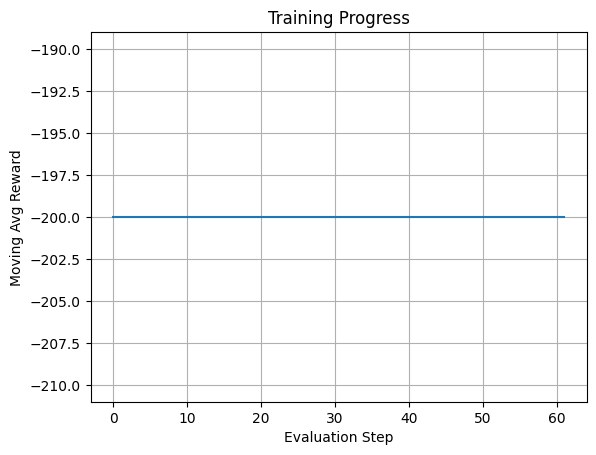

=== A2C on MountainCar-v0 Final Reward: -200.00

=== Running GRPO on PongNoFrameskip-v4 ===


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


hi)
CNNPolicy(
  (net): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=3136, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=6, bias=True)
  )
)


/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Steps 8192: Avg Reward = -21.00, Moving Avg (10) = -21.00
Steps 16384: Avg Reward = -20.50, Moving Avg (10) = -20.75
Steps 24576: Avg Reward = -20.00, Moving Avg (10) = -20.50
Steps 32768: Avg Reward = -20.00, Moving Avg (10) = -20.38
Steps 40960: Avg Reward = -21.00, Moving Avg (10) = -20.50
Steps 49152: Avg Reward = -20.00, Moving Avg (10) = -20.42
Steps 57344: Avg Reward = -20.00, Moving Avg (10) = -20.36
Steps 65536: Avg Reward = -20.50, Moving Avg (10) = -20.38
Steps 73728: Avg Reward = -21.00, Moving Avg (10) = -20.44
Steps 81920: Avg Reward = -20.00, Moving Avg (10) = -20.40
Steps 90112: Avg Reward = -20.50, Moving Avg (10) = -20.35
Steps 98304: Avg Reward = -20.00, Moving Avg (10) = -20.30
Steps 106496: Avg Reward = -21.00, Moving Avg (10) = -20.40
Steps 114688: Avg Reward = -21.00, Moving Avg (10) = -20.50
Steps 122880: Avg Reward = -20.00, Moving Avg (10) = -20.40
Steps 131072: Avg Reward = -21.00, Moving Avg (10) = -20.50
Steps 139264: Avg Reward = -21.00, Moving Avg (10) = 

In [ ]:
import gym
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import os

# from models import Policy, Value
# from agent import GeneralAgent
# from trainer import train, evaluate

env_configs = {
    "CartPole-v1": {
        "batch_size": 8192,
        "mini_batch_size": 512,
        "epochs": 10,
        "total_steps": 200_000,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "entropy_bonus": True,
        "entropy_coeff": 0.01,
        "kl_coeff": 0.5,
        "clip_eps": 0.2,
    },
    "LunarLander-v2": {
        "batch_size": 16384,
        "total_steps": 1_000_000,
        "mini_batch_size": 1024,
        "epochs": 10,
        "gamma": 0.99,
        "gae_lambda": 0.95,
        "entropy_bonus": True,
        "entropy_coeff": 0.02, #stronger exploration bonus
        "kl_penalty": True,
        "kl_coeff": 1.0,
        "clip_eps": 0.2,
    },
    "MountainCar-v0": {
      "batch_size": 8192,
      "mini_batch_size": 512,
      "epochs": 10,
      "total_steps": 500_000,
      "gamma": 0.99,
      "gae_lambda": 0.95,
      "entropy_bonus": True,
      "entropy_coeff": 0.02,
      "kl_coeff": 0.5,
      "clip_eps": 0.2,
  },
#     "PongNoFrameskip-v4":{
#       "batch_size": 8192,
#       "mini_batch_size": 512,
#       "epochs": 4,
#       "total_steps": 5_000_000,
#       "gamma": 0.99,
#       "gae_lambda": 0.95,
#       "entropy_bonus": True,
#       "entropy_coeff": 0.01,
#       "kl_coeff": 0.2,
#       "clip_eps": 0.1,
#   },
  
}

algorithms = ["GRPO", "GRPO_KL", "PPO_CLIP", "PPO_KL", "A2C"]


final_results = []

for env_id, base_config in env_configs.items():
    for algo in algorithms:
        print(f"\nRunning {algo} on {env_id}:")


        config = base_config.copy()
        config["algo"] = algo
        config["kl_penalty"] = algo in ["GRPO_KL", "PPO_KL"]

        if "Pong" in env_id:
            #env = gym.make(env_id, frameskip=1, repeat_action_probability=0.0)
            env = gym.make(env_id)
            env = gym.wrappers.AtariPreprocessing(env, grayscale_obs=True, scale_obs=False, frame_skip=1, noop_max=30)
            env = gym.wrappers.FrameStack(env, 4)
            act_dim = env.action_space.n
            policy = CNNPolicy(act_dim)
            print(policy)
            value_fn = CNNValue()
        else:
            env = gym.make(env_id)
            obs_dim = env.observation_space.shape[0]
            act_dim = env.action_space.n
            policy = Policy(obs_dim, act_dim)
            value_fn = Value(obs_dim)

        optimizer = optim.Adam(list(policy.parameters()) + list(value_fn.parameters()), lr=3e-4)
        agent = GeneralAgent(policy, value_fn, config)

        reward_curve = train(env, agent, config)

        final_reward = evaluate(env, agent.policy, num_episodes=10)

        final_results.append({
            "Environment": env_id,
            "Algorithm": algo,
            "FinalReward": final_reward
        })

        print(f"{algo} on {env_id} Final Reward: {final_reward:.2f}")



In [ ]:
# # Kaggle-ready GRPO trainer for Pong

# # Cell 1: Setup
# !pip install gym[atari,accept-rom-license] opencv-python --quiet

# import os, torch, random, numpy as np
# import gym
# import torch.nn as nn
# import torch.nn.functional as F
# import matplotlib.pyplot as plt

# # Set device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)

# # Cell 2: Frame Processor (simplified Atari wrapper)
# import cv2
# from collections import deque

# class AtariWrapper:
#     def __init__(self, env_id):
#         self.env = gym.make(env_id)
#         self.env = gym.wrappers.AtariPreprocessing(self.env, frame_skip=1, grayscale_obs=True)
#         self.env = gym.wrappers.FrameStack(self.env, 4)

#     def reset(self):
#         obs = self.env.reset()
#         return self._process(obs)

#     def step(self, action):
#         # next_obs, reward, done, info = self.env.step(action)
#         # return self._process(next_obs), reward, done, info
#         next_obs, reward, terminated, truncated, info = self.env.step(action)
#         done = terminated or truncated
#         return self._process(next_obs), reward, done, info


#     def _process(self, obs):
#         if isinstance(obs, tuple):  # sometimes obs is a tuple (obs, info)
#             obs = obs[0]
#         if hasattr(obs, "_frames"):  # gym's LazyFrames
#             obs = np.stack(obs._frames, axis=0)
#         else:
#             obs = np.array(obs)
#         return torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0) / 255.0

#     def render(self):
#         self.env.render()

#     def close(self):
#         self.env.close()

#     def sample_action(self):
#         return self.env.action_space.sample()

#     @property
#     def action_space(self):
#         return self.env.action_space.n

# # Cell 3: CNN Policy
# class CNNPolicy(nn.Module):
#     def __init__(self, num_actions):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(4, 32, 8, stride=4), nn.ReLU(),
#             nn.Conv2d(32, 64, 4, stride=2), nn.ReLU(),
#             nn.Conv2d(64, 64, 3, stride=1), nn.ReLU(),
#         )
#         self.fc = nn.Sequential(
#             nn.Linear(7*7*64, 512), nn.ReLU(),
#             nn.Linear(512, num_actions)
#         )

#     def forward(self, x):
#         x = self.conv(x)
#         x = x.view(x.size(0), -1)
#         return self.fc(x)

# # Cell 4: Rollout & GRPO

# def run_episode(env, policy, max_steps=10000):
#     obs = env.reset()
#     rewards, log_probs = [], []
#     total_reward = 0
#     for _ in range(max_steps):
#         logits = policy(obs)
#         probs = F.softmax(logits, dim=-1)
#         dist = torch.distributions.Categorical(probs)
#         action = dist.sample()
#         log_prob = dist.log_prob(action)

#         next_obs, reward, done, _ = env.step(action.item())
#         rewards.append(reward)
#         log_probs.append(log_prob)
#         total_reward += reward
#         obs = next_obs
#         if done:
#             break
#     return log_probs, rewards, total_reward


# def grpo_update(log_probs, rewards, optimizer, beta=0.04):
#     R = sum(rewards)  # total return
#     rewards = torch.tensor(rewards, dtype=torch.float32, device=device)
#     baseline = rewards.mean()
#     advantage = R - baseline

#     loss = -torch.stack(log_probs).sum() * advantage  # reward-weighted log probs
#     loss += beta * (torch.stack(log_probs)**2).sum()  # entropy-like regularization

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     return loss.item(), R

# # Cell 5: Train

# env = AtariWrapper("PongNoFrameskip-v4")
# policy = CNNPolicy(env.action_space).to(device)
# optimizer = torch.optim.Adam(policy.parameters(), lr=2.5e-4)

# rewards = []
# steps = 1000

# for step in range(steps):
#     log_probs, ep_rewards, total_r = run_episode(env, policy)
#     loss, ret = grpo_update(log_probs, ep_rewards, optimizer)
#     rewards.append(ret)
#     print(f"Step {step+1}: Return = {ret:.1f}, Loss = {loss:.2f}")

# # Cell 6: Plot
# plt.plot(rewards)
# plt.title("GRPO on Pong")
# plt.xlabel("Episode")
# plt.ylabel("Total Reward")
# plt.grid(True)
# plt.show()

# env.close()
